In [4]:
import pandas as pd
import glob
import os

# 1. 读取所有CSV文件
# 假设你的csv文件都在 'data' 文件夹下
file_path = "./景点评论数据/*.csv" 
all_files = glob.glob(file_path)

df_list = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    df_list.append(df)

# 2. 合并为一个DataFrame
df_all = pd.concat(df_list, axis=0, ignore_index=True)

# 3. 初步查看数据
print(f"总评论数: {len(df_all)}")
display(df_all.head())

# 4. 基础清洗 (去重、去空)
df_all.drop_duplicates(subset=['评论内容'], inplace=True) # 假设评论列名叫'评论内容'
df_all.dropna(subset=['评论内容'], inplace=True)

总评论数: 64488


,景点名称,用户名称,评分,评论内容,爬取时间
0,沈阳博物馆,匿名用户,5,能遇到金牌讲解员是一种什么感受，如果当年上中学时历史老师也是这种水平，高考我就果断选历史专业啦！,2025-11-12 16:48:43
1,沈阳博物馆,匿名用户,5,司导讲解耐心，细致，服务热情周到。,2025-11-12 16:48:43
2,沈阳博物馆,匿名用户,5,司导讲解非常棒，不虚此行。,2025-11-12 16:48:44
3,沈阳博物馆,匿名用户,5,交通便利，房间干净,2025-11-12 16:48:44
4,沈阳博物馆,匿名用户,5,十分方便快捷,2025-11-12 16:48:44


In [5]:
import jieba
import re

# 1. 加载停用词表 (你需要自己下载一个中文停用词txt，或者手动定义一个列表)
# 这里是一个简单的示例列表
stopwords = ['的', '了', '我', '是', '在', '也', '很', '非常', '去', '我们', '这里', '有'] 

def clean_text(text):
    # 去除表情包、特殊符号，只保留中文、英文和数字
    text = re.sub(r"[^\u4e00-\u9fa5a-zA-Z0-9]", "", str(text))
    return text

def split_words(text):
    words = jieba.lcut(text)
    return [w for w in words if w not in stopwords and len(w) > 1] # 去掉停用词和单字

# 应用到DataFrame
df_all['clean_content'] = df_all['评论内容'].apply(clean_text)
df_all['cut_words'] = df_all['clean_content'].apply(split_words)

display(df_all[['评论内容', 'cut_words']].head())

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/8f/11jq_86x73b8m5_mb4wgpcl00000gn/T/jieba.cache
Loading model cost 0.207 seconds.
Prefix dict has been built successfully.


,评论内容,cut_words
0,能遇到金牌讲解员是一种什么感受，如果当年上中学时历史老师也是这种水平，高考我就果断选历史专业啦！,"[遇到, 金牌, 讲解员, 一种, 什么, 感受, 如果, 当年, 中学, 历史, 老师, ..."
1,司导讲解耐心，细致，服务热情周到。,"[司导, 讲解, 耐心, 细致, 服务, 热情周到]"
2,司导讲解非常棒，不虚此行。,"[司导, 讲解, 不虚此行]"
3,交通便利，房间干净,"[交通, 便利, 房间, 干净]"
4,十分方便快捷,"[十分, 方便快捷]"


In [8]:
!pip install matplotlib seaborn plotly pandas numpy jieba snownlp

In [9]:
from snownlp import SnowNLP

def get_sentiment_score(text):
    if not text:
        return 0.5
    return SnowNLP(text).sentiments

df_all['sentiment_score'] = df_all['clean_content'].apply(get_sentiment_score)

# 查看情感分数分布
print(df_all['sentiment_score'].describe())

# 💾 导出带有情感分数的原始数据
df_all.to_csv('result_with_sentiment.csv', index=False)

count    54541.000000
mean         0.888610
std          0.229710
min          0.000000
25%          0.914485
50%          0.994458
75%          0.999947
max          1.000000
Name: sentiment_score, dtype: float64


In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# 准备数据：将分词后的列表重新组合成空格分隔的字符串
corpus = [' '.join(words) for words in df_all['cut_words']]

# 向量化
vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000)
tf = vectorizer.fit_transform(corpus)

# 训练LDA模型 (假设我们要找 5 个主题)
n_topics = 5
lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)
lda.fit(tf)

# 输出每个主题的前10个关键词
feature_names = vectorizer.get_feature_names_out()
topic_dict = {}

for topic_idx, topic in enumerate(lda.components_):
    top_features_ind = topic.argsort()[:-11:-1]
    top_features = [feature_names[i] for i in top_features_ind]
    topic_dict[f"Topic_{topic_idx+1}"] = top_features
    print(f"Topic {topic_idx+1}: {top_features}")

# 💾 将主题关键词导出
pd.DataFrame(topic_dict).to_csv('result_lda_topics.csv', index=False)

Topic 1: ['上海', '外滩', '陆家嘴', '建筑', '好好', '感受', '历史', '老街', '繁华', '金融中心']
Topic 2: ['博物馆', '值得', '历史', '文化', '可以', '一去', '文物', '博物院', '了解', '地方']
Topic 3: ['讲解', '老师', '导游', '孩子', '博物馆', '专业', '知识', '历史', '讲解员', '小时']
Topic 4: ['不错', '景色', '可以', '体验', '值得', '性价比', '推荐', '小镇', '好玩', '迪士尼']
Topic 5: ['草原', '地方', '哈尔滨', '可以', '中央大街', '很多', '一个', '就是', '感觉', '美丽']


In [12]:
import pandas as pd
import numpy as np
import glob
import jieba
import re
from snownlp import SnowNLP
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# --- 绘图设置 ---
# 设置中文字体，解决 Matplotlib 中文乱码问题
# Windows 系统通常使用 SimHei，Mac 使用 Arial Unicode MS 或 Heiti TC
plt.rcParams['font.sans-serif'] = ['SimHei'] # 如果是Mac，尝试改为 ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False # 解决负号显示问题
sns.set_theme(style="whitegrid", font='SimHei') # 设置 seaborn 主题和字体

# --- 数据加载与预处理 (回顾) ---
# 假设你的csv文件在 data 文件夹下，并且有 'attraction_name' (景点名称) 列
file_path = "./data/*.csv"
all_files = glob.glob(file_path)
df_list = []
for filename in all_files:
    # 读取时尝试提取景点名称，假设文件名就是景点名，例如 "./data/故宫.csv"
    attraction_name = os.path.basename(filename).replace('.csv', '')
    df = pd.read_csv(filename, index_col=None, header=0)
    # 极其重要：添加景点名称列，后续排名要用
    df['attraction_name'] = attraction_name 
    df_list.append(df)

df_all = pd.concat(df_list, axis=0, ignore_index=True)
df_all.dropna(subset=['评论内容'], inplace=True) # 假设评论列名为 '评论内容'

# 简单的清洗函数
def clean_text_simple(text):
    text = re.sub(r"[^\u4e00-\u9fa5，。！？、]", "", str(text)) # 只保留中文和标点用于情感分析
    return text

df_all['clean_text'] = df_all['评论内容'].apply(clean_text_simple)
print(f"数据加载完成，共 {len(df_all)} 条评论。")
df_all.head(2)

ValueError: No objects to concatenate

In [13]:
import pandas as pd
import glob
import os

# ******* 关键修正点 1：检查文件路径 *******
# 请确保这个路径正确指向你的文件夹！
# 1. 如果文件夹在当前Jupyter文件目录下：
folder_name = "景点评论数据" 
file_path = os.path.join(folder_name, "*.csv") # 得到类似 '景点评论数据/*.csv'

# 2. 如果你的文件就是直接放在当前目录下（不太推荐）：
# file_path = "*.csv" 

print(f"当前搜索路径为: {file_path}")

# --- 读取所有 CSV 文件 ---
all_files = glob.glob(file_path)

# --- 关键检查点 ---
print(f"找到的文件数量: {len(all_files)}")

# 如果这里显示找到的文件数量是 0，说明路径或文件名通配符有误！
if len(all_files) == 0:
    print("❌ 警告：未找到任何文件！请检查你的文件夹名称和路径是否正确。")
    # 你可以尝试手动输入一个完整的文件名来测试路径：
    # print(os.path.exists("./景点评论数据/某个景点名_评论.csv"))

# ******* 关键修正点 2：循环读取与合并 *******
df_list = []
for filename in all_files:
    
    # 假设你的文件名是 "景点名称_评论.csv"
    base_name = os.path.basename(filename) # 例如: 故宫_评论.csv
    attraction_name = base_name.replace('_评论.csv', '') # 提取 "故宫"
    
    # 尝试读取 CSV，注意编码问题 (中文数据爬取常是 'utf-8' 或 'gbk')
    try:
        df = pd.read_csv(filename, encoding='utf-8')
    except UnicodeDecodeError:
        df = pd.read_csv(filename, encoding='gbk')
    except Exception as e:
        print(f"读取文件 {filename} 时发生错误: {e}")
        continue # 跳过这个文件
        
    # 假设你的原始列名是：景点名称，用户名称，评分，评论内容，爬取时间
    # 1. 确保原始数据中的“评论内容”列名是准确的
    if '评论内容' not in df.columns:
        print(f"文件 {filename} 中缺少 '评论内容' 列，跳过。")
        continue

    # 2. 从文件名中提取并赋值景点名称（防止文件内容中列名有误）
    df['attraction_name_new'] = attraction_name
    
    df_list.append(df)

# --- 关键修正点 3：合并执行 ---
if df_list:
    df_all = pd.concat(df_list, axis=0, ignore_index=True)
    print("\n✅ 数据合并成功！")
    
    # --- 初步清洗与查看 ---
    df_all.dropna(subset=['评论内容'], inplace=True)
    df_all.rename(columns={'评论内容': 'content', '评分': 'rating', 'attraction_name_new': 'attraction_name'}, inplace=True)
    print(f"总评论数: {len(df_all)}")
    display(df_all.head(2))

else:
    # 重新抛出错误信息，但带上提示
    print("\n❌ 合并失败。 df_list 仍然为空，请检查文件路径和编码问题。")
    # 退出当前代码块，防止执行后续依赖 df_all 的代码

当前搜索路径为: 景点评论数据/*.csv
找到的文件数量: 79

✅ 数据合并成功！
总评论数: 64488


,景点名称,用户名称,rating,content,爬取时间,attraction_name
0,沈阳博物馆,匿名用户,5,能遇到金牌讲解员是一种什么感受，如果当年上中学时历史老师也是这种水平，高考我就果断选历史专业啦！,2025-11-12 16:48:43,沈阳博物馆
1,沈阳博物馆,匿名用户,5,司导讲解耐心，细致，服务热情周到。,2025-11-12 16:48:43,沈阳博物馆


In [14]:
import pandas as pd
import numpy as np
import re
from snownlp import SnowNLP
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
# 导入 jieba 准备分词，但这里情感分析用 SnowNLP，分词用在模块四的关键词分析

# --- 绘图设置（防止中文乱码，需确保你的环境中安装了对应的中文字体） ---
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False 
sns.set_theme(style="whitegrid", font='SimHei') 

# 1. 简单的清洗函数：只保留中文、数字和标点符号，用于情感分析
def clean_text_simple(text):
    # 将输入转换为字符串，去除无关字符，只保留中文、数字和常用标点
    text = re.sub(r"[^\u4e00-\u9fa50-9，。！？、]", "", str(text))
    return text

# 2. 应用清洗，创建 'clean_text' 列
df_all['clean_text'] = df_all['content'].apply(clean_text_simple)

# 3. 计算情感得分
def get_sentiment_score(text):
    if not text or len(text) < 2: 
        return 0.5 # 避免短文本误判
    try:
        return SnowNLP(text).sentiments
    except Exception:
        return 0.5

# 4. 应用计算，创建 'sentiment_score' 列
print("正在进行情感计算 (SnowNLP)...")
df_all['sentiment_score'] = df_all['clean_text'].apply(get_sentiment_score)
print("✅ 情感计算完成。")

正在进行情感计算 (SnowNLP)...
✅ 情感计算完成。



【关键产出：情感分类比例报告】


,分类,比例
0,强烈正面,83.1%
1,中性/负面,10.6%
2,一般正面,6.3%


findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not

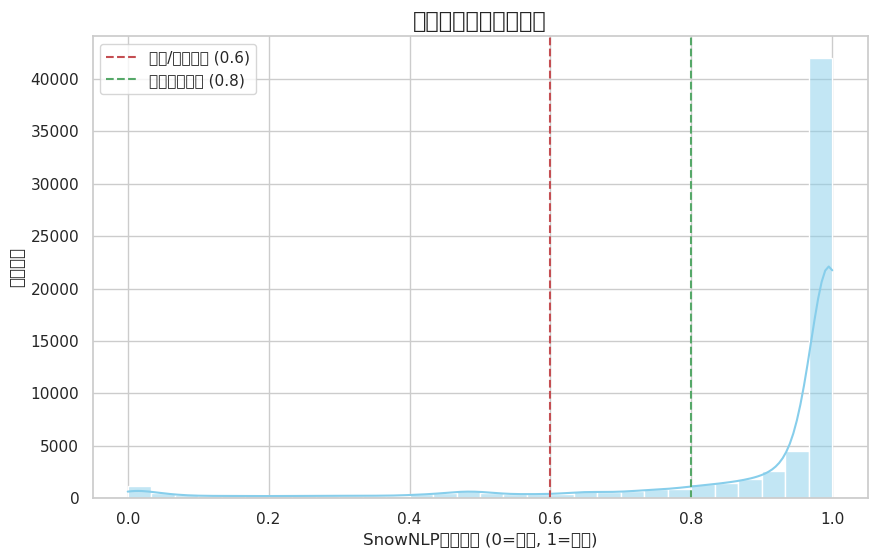

findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not

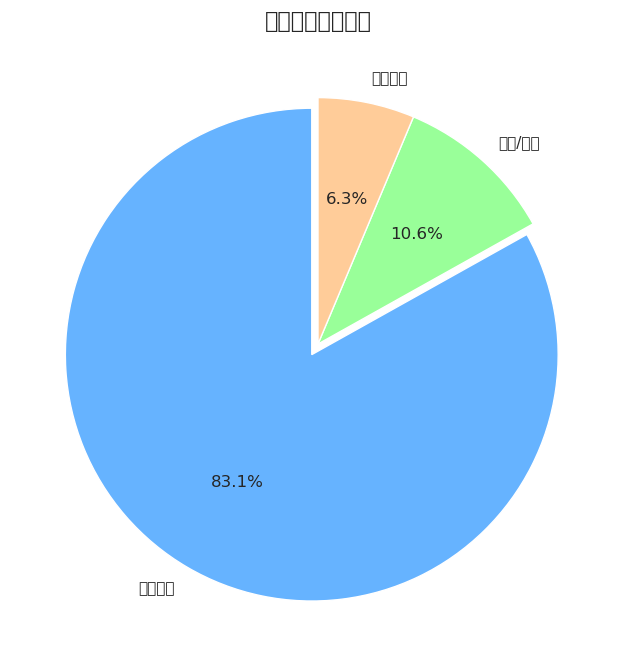

In [15]:
# --- 情感分类体系 ---
def categorize_sentiment(score):
    if score > 0.8:
        return '强烈正面'
    elif 0.6 < score <= 0.8:
        return '一般正面'
    else:
        return '中性/负面' # <= 0.6

df_all['sentiment_category'] = df_all['sentiment_score'].apply(categorize_sentiment)

# --- 关键产出指标：情感分类比例报告 ---
sentiment_counts = df_all['sentiment_category'].value_counts(normalize=True).reset_index()
sentiment_counts.columns = ['分类', '比例']
sentiment_counts['比例'] = (sentiment_counts['比例'] * 100).round(1).astype(str) + '%'

print("\n【关键产出：情感分类比例报告】")
display(sentiment_counts)


# --- 可视化：情感得分分布直方图 ---
plt.figure(figsize=(10, 6))
sns.histplot(data=df_all, x='sentiment_score', bins=30, kde=True, color='skyblue')
plt.title('整体评论情感得分分布', fontsize=16)
plt.xlabel('SnowNLP情感得分 (0=负面, 1=正面)', fontsize=12)
plt.ylabel('评论数量', fontsize=12)
plt.axvline(x=0.6, color='r', linestyle='--', label='中性/负面界限 (0.6)')
plt.axvline(x=0.8, color='g', linestyle='--', label='强烈正面界限 (0.8)')
plt.legend()
plt.show()

# --- 可视化：情感分类占比饼图 ---
plt.figure(figsize=(8, 8))
counts = df_all['sentiment_category'].value_counts()
colors = ['#66b3ff', '#99ff99', '#ffcc99'] 
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90, colors=colors, explode=(0.05, 0, 0))
plt.title('情感分类比例饼图', fontsize=16)
plt.show()